In [64]:
import pandas as pd
import numpy as np
import json
import string
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix
import operator
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from ast import literal_eval

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
import spacy
from spacy.lang.en.examples import sentences

In [65]:
df = pd.read_csv("movies.csv")
df.head()

,movie_id,year,synopsis,genres
0,30924,2005,Cruel But Necessary is the story of Betty Muns...,Drama
1,34841,2012,"Yorkshire, 1974, the Maynard family moves into...",Drama Horror Thriller
2,23408,2017,When a renowned architecture scholar falls sud...,Drama
3,39470,1996,The story dealt with Lord Rama and his retalia...,Children Drama
4,7108,2003,A Thai playboy cons a girl into bed and then l...,Comedy Drama Horror Thriller


In [66]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35488 entries, 0 to 35487
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  35488 non-null  int64 
 1   year      35488 non-null  int64 
 2   synopsis  35488 non-null  object
 3   genres    35488 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [67]:

df = df[~(df['genres'].str.len() == 0)]

In [68]:
#Convert the string labels to lists of strings

genres = [] 

for i in df['genres']: 
  genres.append((i.split(' '))) 

df['genres'] = genres

In [69]:
df['genres'].values[:5]


array([list(['Drama']), list(['Drama', 'Horror', 'Thriller']),
       list(['Drama']), list(['Children', 'Drama']),
       list(['Comedy', 'Drama', 'Horror', 'Thriller'])], dtype=object)

In [70]:
all_genres = sum(genres,[])
len(set(all_genres))

19

In [71]:
all_genres = nltk.FreqDist(all_genres) 
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

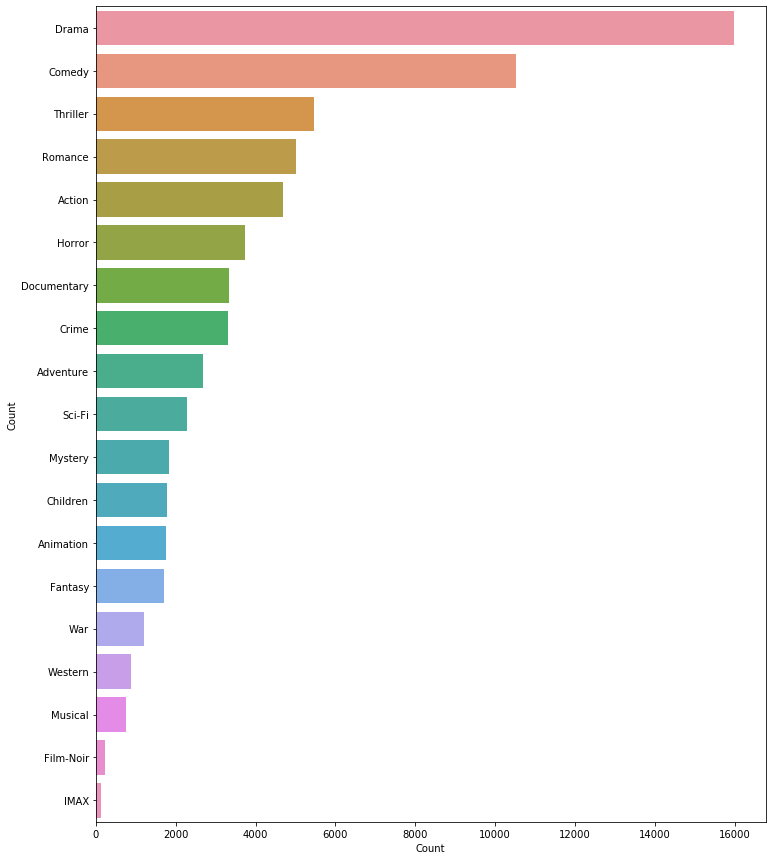

In [72]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

# The function below will visualize the words and their frequency in a set of documents. Let’s use it to find out the most frequent words in the movies

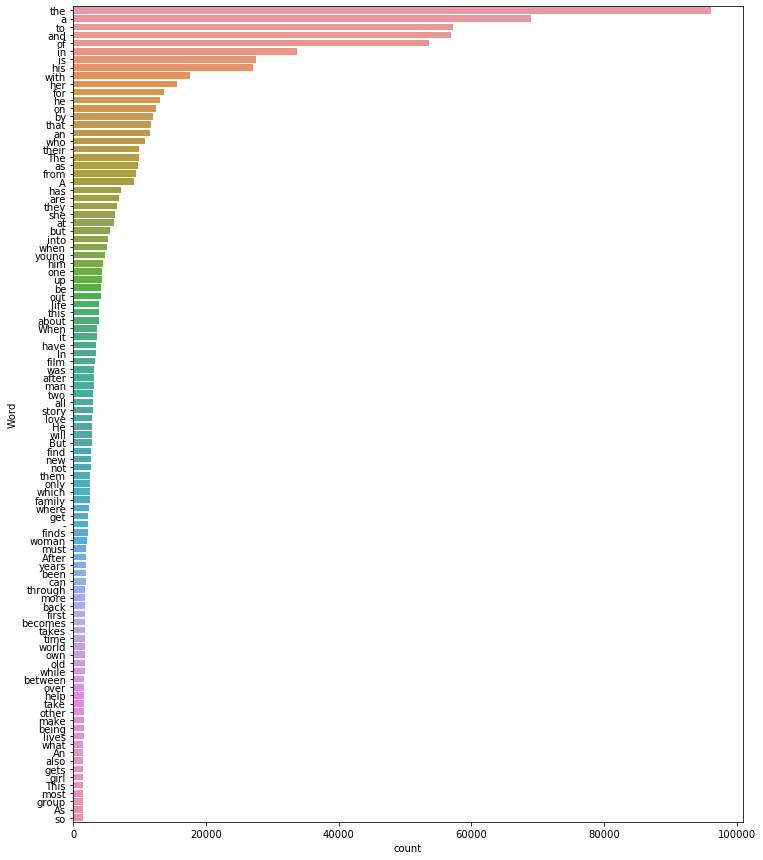

In [73]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(12,15)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 100 most frequent words 
freq_words(df['synopsis'], 100)

### Most of the terms in the above plot are stopwords. These stopwords carry far less meaning than other keywords in the text (they just add noise to the data).
## Creating our stopwords list and adding some more words that are very common in the summaries. 
## Changing the text to lower case, stopwords removal, lemmatizing

In [74]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['one', 'two', 'go','goes', 'get', 'also', 'however', 'tells'] 
stopwords_list += [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('\d+', ' ', text)
    text = text.strip(' ')
    text = word_tokenize(text)
    text = [w for w in text if w not in stopwords_list]
    text = ' '.join(text)
    return text

In [76]:
df['synopsis'] = df['synopsis'].map(lambda x : clean_text(x))


In [77]:
df['synopsis']

0        cruel necessary story betty munson strange jou...
1        yorkshire maynard family moves dream house dre...
2        renowned architecture scholar falls suddenly i...
3        story dealt lord rama retaliation ravana chara...
4        thai playboy cons girl bed leaves finding preg...
                               ...                        
35483    prequel mou gaan dou chan wing yan become unde...
35484    ann husband george son georgie arrive holiday ...
35485    former sports star fallen hard times starts co...
35486    hard hitting western drama starring mitchum or...
35487    abner peacock knotts beloved bird watcher maga...
Name: synopsis, Length: 35488, dtype: object

## I’d also like to normalize the text, aka, perform text normalization. This helps in reducing a word to its base form. For example, the base form of the words ‘produces’, ‘production’, and ‘producing’ is ‘product’. 

In [78]:
df = df.drop(columns=['year'])

In [79]:
df.head()

,movie_id,synopsis,genres
0,30924,cruel necessary story betty munson strange jou...,[Drama]
1,34841,yorkshire maynard family moves dream house dre...,"[Drama, Horror, Thriller]"
2,23408,renowned architecture scholar falls suddenly i...,[Drama]
3,39470,story dealt lord rama retaliation ravana chara...,"[Children, Drama]"
4,7108,thai playboy cons girl bed leaves finding preg...,"[Comedy, Drama, Horror, Thriller]"


# we will treat this multi-label classification problem as a Binary Relevance problem. 
## Hence, we will now one hot encode the target variable, i.e., genre_new by using sklearn’s MultiLabelBinarizer( ). Since there are 18 unique genre tags, there are going to be 18 new target variables.

In [80]:

from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df['genres'])
y = multilabel_binarizer.transform(df['genres'])
df['genres']

0                                  [Drama]
1                [Drama, Horror, Thriller]
2                                  [Drama]
3                        [Children, Drama]
4        [Comedy, Drama, Horror, Thriller]
                       ...                
35483     [Action, Crime, Drama, Thriller]
35484                    [Drama, Thriller]
35485                    [Comedy, Romance]
35486                  [Thriller, Western]
35487                             [Comedy]
Name: genres, Length: 35488, dtype: object

# Before creating TF-IDF features, we will split our data into train and validation sets for training and evaluating our model’s performance. I’m going with a 80-20 split – 80% of the data samples in the train set and the rest in the validation set

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df['synopsis'], y, test_size=0.2, random_state=9)

# Now, it’s time to turn our focus to extracting features from the cleaned version of the movie plots data. For this article, I will be using TF-IDF features.
## Now we can create features for the train and the validation set:



In [82]:
vectorizer = TfidfVectorizer(max_df=0.8 , lowercase=False,max_features=20000)
X_train = vectorizer.fit_transform(X_train)



In [83]:
df1 = pd.DataFrame(X_train[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
df1 = df1.sort_values('TF-IDF', ascending=False)
print (df1.head(25))

                TF-IDF
elisabeth     0.589132
hamburg       0.290000
happy         0.197120
dies          0.191169
erich         0.159133
long          0.153644
confusing     0.143964
disappointed  0.142062
budding       0.134253
confesses     0.131618
affections    0.131136
inherits      0.125865
time          0.123762
studies       0.121299
loyal         0.119767
eric          0.119767
stays         0.119050
love          0.114542
spent         0.111580
musician      0.107917
visits        0.106967
ready         0.106851
farm          0.103059
meeting       0.101991
asks          0.099805


In [84]:
X_test = vectorizer.transform(X_test)


# LogisticRegression
## I will build a Logistic Regression model as it is quick to train on limited computational power
### We will use sk-learn’s OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem:

In [186]:
lr_grid = {
    'estimator__penalty' : ['l1', 'l2'],
    'estimator__C' : [ 1e4, 1e10],
    'estimator__class_weight' : ['balanced', None],
    'estimator__solver' : ['lbfgs', 'liblinear'],
    'estimator__multi_class' : ['ovr', 'multinomial']
}

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
logreg_tfidf_gs = GridSearchCV(clf, param_grid = lr_grid, cv = 5)
logreg_tfidf_gs.fit(X_train, y_train)
print(logreg_tfidf_gs.best_score_)
model_resultstfidf['Logistic Regression'] = logreg_tfidf_gs.best_score_

0.1477632969355407


# It is a binary one-dimensional array of length 20. Basically, it is the one-hot encoded form of the unique genre tags. We will have to find a way to convert it into movie genre tags.

## We will use the inverse_transform( ) function along with the MultiLabelBinarizer( ) object to convert the predicted arrays into movie genre tags:

In [187]:
y_pred = logreg_tfidf_gs.predict(X_test)


In [188]:
f1_score(y_test, y_pred, average="micro")


0.4744228157537347

# These predictions were made based on a threshold value of 0.5, which means that the probabilities greater than or equal to 0.5 were converted to 1’s and the rest to 0’s.

## Let’s try to change this threshold value and see if that improves our model’s score:
### I did a grid search to do this


# Dummy Classifier
### A dummy classifier is a type of classifier which does not generate any insight about the data and classifies the given data using only simple rules. It is used only as a simple baseline for the other classifiers i.e. any other classifier is expected to perform better on the given dataset.

In [67]:
from sklearn.dummy import DummyClassifier
dummy_grid = {
    'estimator__strategy': ['most_frequent', 'stratified', 'prior', 'uniform', 'constant']
}
dummy = DummyClassifier( random_state = 42)
clf = OneVsRestClassifier(dummy)
dummy_gs = GridSearchCV(clf, param_grid = dummy_grid, cv = 5)
dummy_gs.fit(X_train, y_train)
print(dummy_gs.best_score_)

0.03039802747446284


In [68]:
y_pred = dummy_gs.predict(X_test)


In [71]:

from sklearn.metrics import accuracy_score, classification_report
print('Test Accuracy score:', accuracy_score(y_test, y_pred))

Test Accuracy score: 0.03071287686672302


In [101]:
for i in range(5): 
  print("\nPredicted genre: ",multilabel_binarizer.inverse_transform(y_pred)[i]) 
  print("Actual genre: ",df['genres'][i])
  print('#################################')


Predicted genre:  ()
Actual genre:  ['Drama']
#################################

Predicted genre:  ('Action', 'Adventure', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller')
Actual genre:  ['Drama', 'Horror', 'Thriller']
#################################

Predicted genre:  ('Comedy', 'Drama')
Actual genre:  ['Drama']
#################################

Predicted genre:  ('Drama',)
Actual genre:  ['Children', 'Drama']
#################################

Predicted genre:  ()
Actual genre:  ['Comedy', 'Drama', 'Horror', 'Thriller']
#################################


In [ ]:
model_resultstfidf = {}
mnb_grid = {
    'estimator__alpha': [0, 0.2, 0.5, 0.8, 1.0],
    'estimator__fit_prior' : [True, False],
 'estimator__class_prior' : [None, [.4, .3, 0.08, .07, .06, .06], [.167, .167, .167, .167, .167, .167]]
}


mnb = MultinomialNB()
clf = OneVsRestClassifier(mnb)
mnb_grid = GridSearchCV(clf, param_grid = mnb_grid, cv = 5)
mnb_grid.fit(X_train, y_train)
print(mnb_grid.best_score_)

model_resultstfidf['Multinomial Bayes'] = mnb_grid.best_score_

0.20517787953504754


# Decision Tree
### creates the classification model by building a decision tree

In [192]:
grid = {
    'estimator__criterion': ['gini', 'entropy'],
    'estimator__max_depth': [1, 2, 5, 10],
    'estimator__min_samples_split': [1, 5, 10, 20]
}



dt_clf = DecisionTreeClassifier (random_state = 42)
clf = OneVsRestClassifier(dt_clf)
gs_tfidf_tree = GridSearchCV(clf, param_grid = grid, cv = 5)
gs_tfidf_tree.fit(X_train, y_train)

print(gs_tfidf_tree.best_score_)
model_resultstfidf['Decision Tree'] = gs_tfidf_tree.best_score_

0.13082071151814018


# SGD
### applying it to the regularized linear methods can help building an estimator for classification and regression problems. The SGD classifier works well with large-scale datasets and it is an efficient and easy to implement method.

In [194]:
grid = {
    'estimator__loss' : ['hinge', 'log'],
    'estimator__penalty' : ['l2', 'l1'],
    'estimator__alpha' : [1e-3, 1e-4, 1e-5],
    'estimator__max_iter' : [20, 25, 30],
    'estimator__class_weight' : ['balanced', None]
}


sgd = SGDClassifier(random_state=42)
clf = OneVsRestClassifier(sgd)
sgd_tfidf_gs = GridSearchCV(clf, param_grid = grid, cv = 5)
sgd_tfidf_gs.fit(X_train, y_train)

print(sgd_tfidf_gs.best_score_)
model_resultstfidf['SGD'] = sgd_tfidf_gs.best_score_

0.22388164846777037


In [195]:
from sklearn.metrics import accuracy_score, classification_report
print('Test Accuracy score:', accuracy_score(y_test, y_pred_new))
print(classification_report(y_test, y_pred_new))

Test Accuracy score: 0.19456184840800225
              precision    recall  f1-score   support

           0       0.58      0.48      0.53       998
           1       0.59      0.23      0.33       556
           2       0.78      0.27      0.40       355
           3       0.56      0.16      0.25       360
           4       0.54      0.73      0.62      2121
           5       0.51      0.35      0.41       674
           6       0.80      0.62      0.70       654
           7       0.56      0.89      0.69      3152
           8       0.68      0.16      0.25       327
           9       0.00      0.00      0.00        46
          10       0.72      0.51      0.59       757
          11       0.00      0.00      0.00        24
          12       0.20      0.01      0.03       136
          13       0.47      0.12      0.19       374
          14       0.50      0.39      0.44       993
          15       0.72      0.37      0.49       459
          16       0.51      0.43      0

# LinearSVC
### The objective of a Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit" hyperplane that divides, or categorizes, your data. From there, after getting the hyperplane, you can then feed some features to your classifier to see what the "predicted" class is
#### Kernel trick allows the inner product of mapping function instead of the data points,The kernel is a way of computing the dot product of two vectors x and y in some (very high dimensional) feature space.

In [62]:
# Gridsearch to determine the value of C

clf = OneVsRestClassifier(SVC(kernel='linear', probability=True))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average="micro")





0.36005442176870744

In [ ]:
tuned_parameters = [
    { "estimator__gamma": [1e-3, 1e-4], "estimator__C": [1, 10, 100, 1000]}
]
svc = SVC(kernel='linear', probability=True)
clf = OneVsRestClassifier(svc)
grid_lsvc = GridSearchCV(clf, param_grid = tuned_parameters, cv = 5)
grid_lsvc.fit(X_train, y_train)

print(grid_lsvc.best_score_)


# CNN

## Convert the string labels to lists of strings as we did above


In [10]:
test_split = 0.1

# Initial train and test split.

train_df, test_df = train_test_split(df, test_size=0.2, random_state=9)
# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 28390
Number of rows in validation set: 3549
Number of rows in test set: 3549


## Multi-label binarization
### Now we preprocess our labels using the StringLookup layer.
#### A preprocessing layer which maps string features to integer indices.
##### This layer translates a set of arbitrary strings into integer output via a table-based vocabulary lookup.




In [11]:
genres = tf.ragged.constant(train_df["genres"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(genres)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab genres."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)


Vocabulary:

['[UNK]', 'Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Documentary', 'Crime', 'Adventure', 'Sci-Fi', 'Mystery', 'Children', 'Animation', 'Fantasy', 'War', 'Western', 'Musical', 'Film-Noir', 'IMAX']


### Here we are separating the individual unique classes available from the genres and then using this information to represent a given label set with 0's and 1's. Below is an example.

In [12]:
sample_label = train_df["genres"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Drama']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


## We first get percentile estimates of the sequence lengths.

In [13]:
train_df["synopsis"].apply(lambda x: len(x.split(" "))).describe()


count    28390.000000
mean        53.613772
std         33.854674
min          1.000000
25%         27.000000
50%         46.000000
75%         71.000000
max        188.000000
Name: synopsis, dtype: float64

### Notice that 50% of the abstracts have a length of 26. So, any number close to that value is a good enough approximate for the maximum sequence length.



### implement utilities to prepare our datasets.



In [14]:
max_seqlen = 26
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["genres"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["synopsis"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [15]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Dataset preview


In [16]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b"Steve is a college freshman who plays tennis for the school. But he falls desperately in love with Shelly, also a tennis player. It's all downhill from there. Steve can't eat, he can't sleep, his grades drop, and he gets kicked off the tennis team. What can he do? Well, his resourceful friend suggest turning Steve into a woman in order to get him close to Shelly who doesn't know he is alive."
Label(s): ['Comedy']
 
Abstract: b"A woman takes in boarders to support her husband's harebrained financial schemes."
Label(s): ['Comedy']
 
Abstract: b'Two housewives in America in the 1950s, Mrs Fairytale and her best friend Mrs Emerald, meet every day to share their quiet and bourgeois lives, but the fa\xc3\xa7ade of perfection slowly crumbles to reveal terrible secrets.'
Label(s): ['Comedy']
 
Abstract: b"The Hangover crew heads to Thailand for Stu's wedding. After the disaster of a bachelor party in Las Vegas last year, Stu is playing it safe with a mellow pre-wedding brunch. Howe

### We first calculate the number of unique words present in the abstracts.



In [17]:
vocabulary = set()
train_df["synopsis"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

115089


### We now create our vectorization layer and map() to the tf.data.Datasets created earlier.



In [18]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

### Create a text classification model
### We will keep our model simple -- it will be a small stack of fully-connected layers with ReLU as the non-linearity.

In [19]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            #layers.Embedding(vocabulary_size, 100, input_length=150),
            #layers.SpatialDropout1D(0.2),
            #layers.LSTM(200, dropout=0.2, recurrent_dropout=0.2),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

## Train the model
### We will train our model using the binary crossentropy loss. This is because the labels are not disjoint. For a given abstract, we may have multiple categories. So, we will divide the prediction task into a series of multiple binary classification problems. This is also why we kept the activation function of the classification layer in our model to sigmoid

Epoch 1/20
222/222 [==============================] - 22s 94ms/step - loss: 0.2243 - categorical_accuracy: 0.4954 - val_loss: 0.1878 - val_categorical_accuracy: 0.5272
Epoch 2/20
222/222 [==============================] - 20s 89ms/step - loss: 0.0474 - categorical_accuracy: 0.6302 - val_loss: 0.2482 - val_categorical_accuracy: 0.5021
Epoch 3/20
222/222 [==============================] - 20s 88ms/step - loss: 0.0107 - categorical_accuracy: 0.6721 - val_loss: 0.3446 - val_categorical_accuracy: 0.5097
Epoch 4/20
222/222 [==============================] - 20s 87ms/step - loss: 0.0053 - categorical_accuracy: 0.6955 - val_loss: 0.3967 - val_categorical_accuracy: 0.4821
Epoch 5/20
222/222 [==============================] - 19s 86ms/step - loss: 0.0037 - categorical_accuracy: 0.7040 - val_loss: 0.4297 - val_categorical_accuracy: 0.4894
Epoch 6/20
222/222 [==============================] - 19s 86ms/step - loss: 0.0037 - categorical_accuracy: 0.7053 - val_loss: 0.4687 - val_categorical_accuracy:

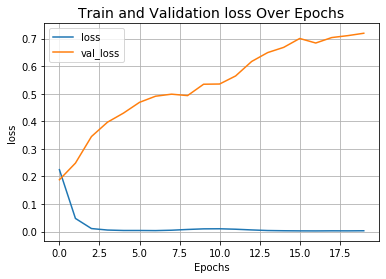

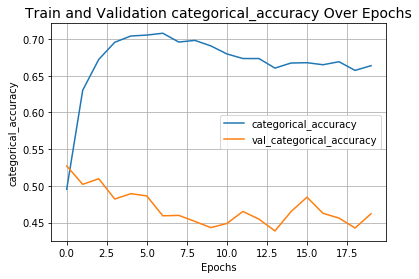

In [20]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

### While training, we notice an initial sharp fall in the loss followed by a gradual decay.
#### we can use different kind of feature extraction method such as ELMo, which I tried but did not have enough hardware. 


In [21]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")


28/28 [==============================] - 1s 24ms/step - loss: 0.7546 - categorical_accuracy: 0.4494
Categorical accuracy on the test set: 44.94%.


## Inference
### An important feature of the preprocessing layers provided by Keras is that they can be included inside a tf.keras.Model. We will export an inference model by including the text_vectorization layer on top of shallow_mlp_model. This will allow our inference model to directly operate on raw strings.

In [41]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:3]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Abstract: b'man monotonous job punching tickets japanese railway night walking home saves jun getting raped hoodlums days later sneaks house gets discovered later watches son subdue insect chemical man gets idea subdue women sleeping wo discovered sneaking home new hobby spirals control confidence grows'
Label(s): ['Drama' 'Crime']
Predicted Label(s): (Thriller, Drama, Romance)
 
Abstract: b'sarah barcant lawyer new york city grew south africa returns childhood dwelling place intercede alex mpondo black south african politician tortured apartheid'
Label(s): ['Drama']
Predicted Label(s): (Drama, Thriller, Children)
 
Abstract: b'city life death takes place height second sino japanese war imperial japanese army captured capital republic china nanjing followed known nanking massacre rape nanking period several weeks wherein tens thousands chinese soldiers civilians killed'
Label(s): ['Drama' 'War']
Predicted Label(s): (Drama, War, Documentary)
 
Abstract: b'wrongly time prison murder man 